<a href="https://colab.research.google.com/github/jzyee/water_stress_proj/blob/master/LSTM1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
% cd /content/gdrive/'My Drive'/water_stress_detection

/content/gdrive/My Drive/water_stress_detection


# imports

In [3]:
# multivariate multi-step data preparation
from numpy import array
from numpy import hstack
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.models import load_model
from keras.layers import Bidirectional
import tensorflow as tf
import pandas as pd
import numpy as np
import os 
import matplotlib.pyplot as plt
from sklearn import preprocessing
import time

import os
os.environ["KERAS_BACKEND"] = "theano"

plt.rcParams["figure.figsize"] = (18,6)

# helper

In [21]:
def combine_eob(site_id):
  '''
  RR - daily sum preciptation
  PP - daily sea level pressure
  TG - daily mean temp
  TN - daily min temp
  TX - daily max temp
  
  '''
  type_list = ['pp', 'rr', 'tg', 'tn', 'tx']

  folder_path = 'data_files/monthly_means/'

  # file naming convention
  # file_cov = 'wind_monthly_'
  # file_name = 'SWIT345'

  start_name_cov = 'monthly_mean_'
  end_name_cov = '_EBTRN'

  out_df = None

  for idx, data_type in enumerate(type_list):
    file_path = folder_path + start_name_cov + data_type + end_name_cov + '.csv'
    if idx == 0:
      df = pd.read_csv(file_path, parse_dates=True).set_index(['Date'])[[site_id]]
      df = df.rename(columns={site_id: data_type})
    
    else:
      df[data_type] = pd.read_csv(file_path, parse_dates=True).set_index(['Date'])[site_id]

  
  return df

def get_climate_and_ndvi(site_id):
  harm_df = pd.read_csv('data_files/processed_harm_ndvi.csv', parse_dates=True)
  harm_df.index = pd.to_datetime(harm_df.iloc[:,0], format='%Y-%m-%d') 
  harm_df = harm_df.iloc[:,1:]
  harm_df.index.name = 'Date'
  # filter out the useable dates
  harm_df = harm_df.loc[(harm_df.index > '1986') & (harm_df.index < '2019')]
  # get the climate data
  df = combine_eob(site_id)
  df = df.loc[(df.index > '1986') & (df.index < '2019')]

  df['ndvi'] = harm_df[site_id]
  return df

def format_cols_casualimpact(df, y_col_name):
  '''
  description: formating column names to fit casual impact function

                example of format:
                data = pd.DataFrame({'x0': x0, 'x1': x1, 'y': y}, 
                                     columns=['y', 'x0', 'x1'])

  returns: dataframe with correct columns names as seen in example

  '''
  old_list = df.columns.to_list()
  new_cols = {}
  
  for idx, col in enumerate(old_list):
    if col != y_col_name:
      new_cols['x'+str(idx)] = col
    else:
      new_cols['y'] = y_col_name

  df.columns = new_cols
  
  #rearranging cols
  rearrange_cols = list([df.columns[-1]]) + list(df.columns[:-1])
  df = df[rearrange_cols]

  return(df)

def make_folder(filename='init_LSTM_model.h5'):

  folder_path = '/model_data/' 
  file_loc = folder_path + filename
  if not os.path.exists(folder_path):
      os.makedirs(folder_path)

  return file_loc

# split a multivariate sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# check if we are beyond the dataset
		if out_end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:out_end_ix, :]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)
 
def plot_history(history):
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.plot(history.history['loss'], label='loss')
  plt.xlabel('epochs')
  plt.ylabel('loss(MSE)')
  plt.legend()

def format_spei(spei_df):
  spei_df.index = spei_df['siteID']
  spei_df = spei_df.iloc[:,1:].T
  spei_df.index = pd.to_datetime(spei_df.index, format='x%Y.%m.%d')
  spei_df.index = spei_df.index.rename('date') 
  spei_df = spei_df.resample('M').mean()
  #full years only
  spei_df = spei_df.loc[(spei_df.index > '1986') & (spei_df.index < '2019')]
  return spei_df

def get_climate_ndvi_and_spei(site):
  spei_df = pd.read_csv('SPEI_folder/SPEI_monthly_EBTRNsites.csv', parse_dates=True)
  spei_df = format_spei(spei_df)

  climate_ndvi = get_climate_and_ndvi(site)
  climate_ndvi['spei'] = spei_df[site]

  return climate_ndvi

def get_all(site):
  out_df = get_climate_ndvi_and_spei(site)

  season_comp = pd.read_csv('synthetic_component/wave.csv', index_col='date')
  season_comp.index = pd.to_datetime(season_comp.index, format='%Y-%m-%d')
  season_comp = season_comp.loc[(season_comp.index > '1986') & (season_comp.index < '2019')]


  out_df = pd.concat([season_comp, out_df], axis=1, sort=False)

  return out_df

def get_norm_drought_val(raw_spei):
  X_std = (-1 - raw_data.min()) / (raw_data.max() - raw_data.min())
  minus_1_norm_val = X_std * (1 - 0) + 0
  return minus_1_norm_val

site =  'UK53'#'SWIT345'
raw_data = get_all(site)
d_val = get_norm_drought_val(raw_data['spei'])
display(raw_data)

,wave,pp,rr,tg,tn,tx,ndvi,spei
1986-01-31,-0.169239,1006.667757,4.877419,2.856774,0.370645,5.450000,0.607394,1.223793
1986-02-28,-0.161670,1018.825015,0.114286,-1.985714,-4.468214,0.690357,0.372279,-1.976280
1986-03-31,-0.110790,1009.858080,2.880645,4.472903,0.868387,8.128387,0.481628,0.649800
1986-04-30,-0.030229,1011.053348,3.260000,4.765000,1.069000,8.637333,0.590977,1.364762
1986-05-31,0.058431,1012.016144,2.345161,10.121290,6.479355,13.722580,0.700326,0.115008
...,...,...,...,...,...,...,...,...
2018-08-31,0.162777,1016.093564,1.454839,16.508709,12.399677,20.089354,0.656597,-0.773454
2018-09-30,0.113326,1019.923349,3.076667,13.773333,9.799333,16.893666,0.670217,0.013928
2018-10-31,0.033514,1017.987112,2.458065,10.530645,7.170645,13.943225,0.683836,-0.317202
2018-11-30,-0.055276,1009.413348,2.256667,8.343000,5.860333,10.593666,0.584051,0.598589


# Scaled -1 for spei

In [20]:
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html

X_std = (-1 - raw_data['spei'].min()) / (raw_data['spei'].max() - raw_data['spei'].min())
minus_1_norm_val = X_std * (1 - 0) + 0
minus_1_norm_val

0.31050167722387

# normalize data

In [22]:

def norm_raw_data(raw_data):
  norm_data = raw_data.copy()

  for col in raw_data:
    if col not in ['ndvi']:
      min_max_scaler = preprocessing.MinMaxScaler()
      norm_data[col] = min_max_scaler.fit_transform(raw_data[[col]].values)

  return norm_data

norm_data = norm_raw_data(raw_data)
norm_data


,wave,pp,rr,tg,tn,tx,ndvi,spei
1986-01-31,0.000000,0.352752,0.600720,0.236373,0.296684,0.202194,0.607394,0.785776
1986-02-28,0.022362,0.678435,0.000000,0.000000,0.026750,0.000000,0.372279,0.101849
1986-03-31,0.172687,0.438218,0.348889,0.315259,0.324450,0.315975,0.481628,0.663101
1986-04-30,0.410702,0.470239,0.396733,0.329517,0.335641,0.337595,0.590977,0.815905
1986-05-31,0.672644,0.496031,0.281355,0.590970,0.637455,0.553621,0.700326,0.548804
...,...,...,...,...,...,...,...,...
2018-08-31,0.980932,0.605262,0.169069,0.902754,0.967717,0.824088,0.656597,0.358920
2018-09-30,0.834828,0.707858,0.373611,0.769234,0.822658,0.688332,0.670217,0.527201
2018-10-31,0.599028,0.655988,0.295594,0.610951,0.676018,0.562994,0.683836,0.456431
2018-11-30,0.336702,0.426304,0.270194,0.504167,0.602923,0.420702,0.584051,0.652156


# model build

# splitting data into train, val, test

In [23]:
dataset = norm_data
ttl_len = len(dataset)
train = np.array(dataset.iloc[:int(ttl_len * 0.7)])
val = np.array(dataset.iloc[int(ttl_len * 0.7):int(ttl_len * 0.8)])
test = np.array(dataset.iloc[int(ttl_len * 0.8):])

print(train.shape)
print(val.shape)
print(test.shape)

(277, 8)
(39, 8)
(80, 8)


In [24]:
n_steps_in, n_steps_out = 12, 6

train_X, train_y = split_sequences(train, n_steps_in, n_steps_out)
val_X, val_y = split_sequences(val, n_steps_in, n_steps_out)
test_X, test_y = split_sequences(test, n_steps_in, n_steps_out)

# print(test)

n_features = train_X.shape[2]
print(n_features)

8


# initial model training 

## steps in = 12 , steps out 6

In [25]:
n_steps_in, n_steps_out = 12, 6

train_X, train_y = split_sequences(train, n_steps_in, n_steps_out)
val_X, val_y = split_sequences(val, n_steps_in, n_steps_out)
test_X, test_y = split_sequences(test, n_steps_in, n_steps_out)

# print(test)

n_features = train_X.shape[2]
print(n_features)

8


stacked LSTM autoencoder

time taken: 49.941897999999995
1/1 [==============================] - 0s 1ms/step - loss: 0.0130
val loss: 0.013048643246293068
2/2 [==============================] - 0s 8ms/step - loss: 0.0150
test loss: 0.015032412484288216


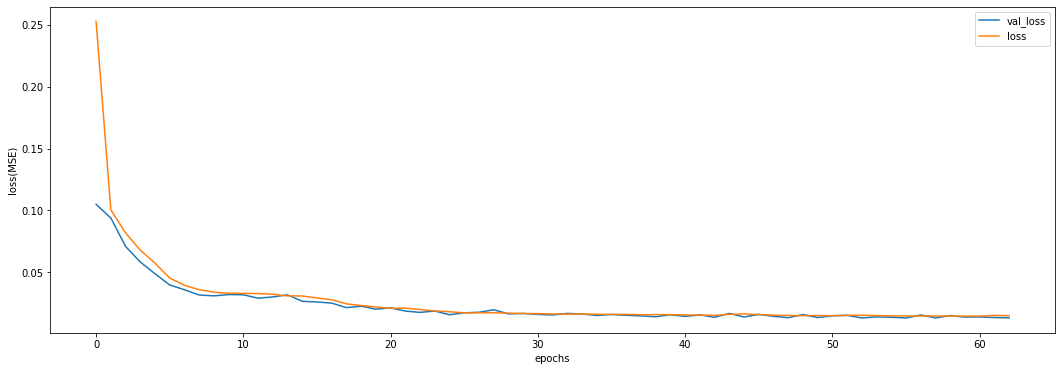

In [26]:
from numpy.random import seed



seed(1)
tf.random.set_seed(1)

# define model
model = Sequential()
model.add(LSTM(200, activation='relu', input_shape=(n_steps_in, n_features)))
model.add(RepeatVector(n_steps_out))
model.add(LSTM(200, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(n_features)))
model.compile(optimizer='adam', loss='mse')

# where to store the init model weights
file_loc = make_folder()
mc = ModelCheckpoint(file_loc, monitor='val_loss', mode='min', save_best_only=True)
es = EarlyStopping(monitor='val_loss', mode='min', patience=10)
# fit model
t0= time.clock()
history = model.fit(train_X, train_y, validation_data=(val_X, val_y), epochs=100, verbose=0, callbacks=[mc,es])
t1= time.clock() - t0
print('time taken:', t1)
saved_model = load_model(file_loc)
print('val loss:', saved_model.evaluate(val_X, val_y))
print('test loss:', saved_model.evaluate(test_X, test_y))



plot_history(history)

time taken: 18.854241000000002
1/1 [==============================] - 0s 1ms/step - loss: 0.0138
val loss: 0.013755165971815586
2/2 [==============================] - 0s 4ms/step - loss: 0.0155
test loss: 0.015533779747784138


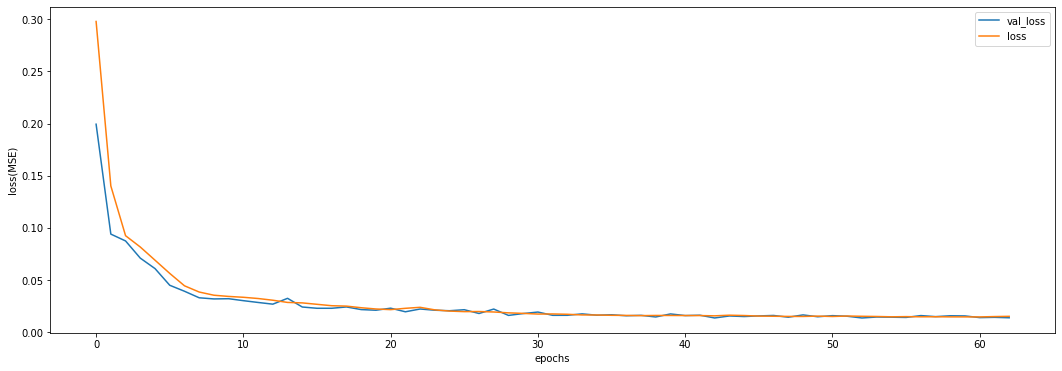

In [27]:
from numpy.random import seed



seed(1)
tf.random.set_seed(1)

# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_steps_in, n_features)))
model.add(RepeatVector(n_steps_out))
model.add(LSTM(100, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(n_features)))
model.compile(optimizer='adam', loss='mse')

# where to store the init model weights
file_loc = make_folder()
mc = ModelCheckpoint(file_loc, monitor='val_loss', mode='min', save_best_only=True)
es = EarlyStopping(monitor='val_loss', mode='min', patience=10)

t0= time.clock()
# fit model
history = model.fit(train_X, train_y, validation_data=(val_X, val_y), epochs=100, verbose=0, callbacks=[es,mc])
t1= time.clock() - t0
print('time taken:', t1)

saved_model = load_model(file_loc)
print('val loss:', saved_model.evaluate(val_X, val_y))
print('test loss:', saved_model.evaluate(test_X, test_y))



plot_history(history)

stacked bilstm (200,200)

time taken: 121.92402600000001
1/1 [==============================] - 0s 2ms/step - loss: 0.0123
val loss: 0.01230588648468256
2/2 [==============================] - 0s 13ms/step - loss: 0.0148
test loss: 0.014769562520086765


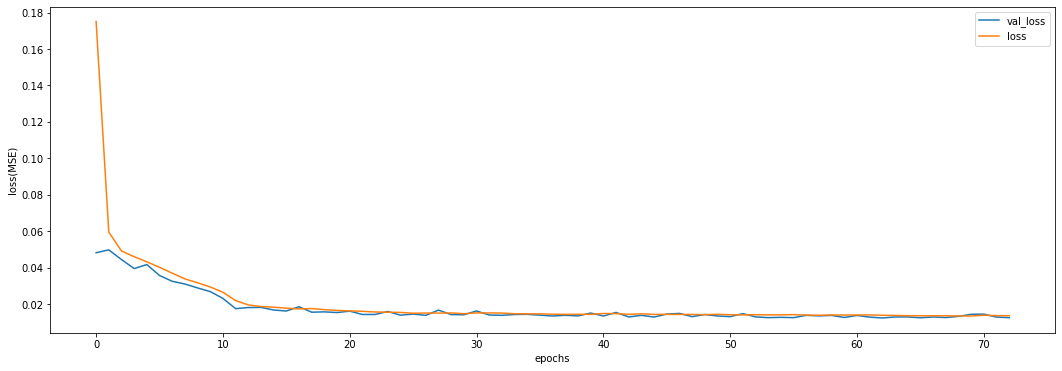

In [28]:
from numpy.random import seed



seed(1)
tf.random.set_seed(1)

# define model
model = Sequential()
model.add(Bidirectional(LSTM(200, activation='relu', input_shape=(n_steps_in, n_features))))
model.add(RepeatVector(n_steps_out))
model.add(Bidirectional(LSTM(200, activation='relu', return_sequences=True)))
model.add(TimeDistributed(Dense(n_features)))
model.compile(optimizer='adam', loss='mse')

# where to store the init model weights
file_loc = make_folder()
mc = ModelCheckpoint(file_loc, monitor='val_loss', mode='min', save_best_only=True)
es = EarlyStopping(monitor='val_loss', mode='min', patience=10)

t0= time.clock()
# fit model
history = model.fit(train_X, train_y, validation_data=(val_X, val_y), epochs=100, verbose=0, callbacks=[es,mc])
t1= time.clock() - t0
print('time taken:', t1)


saved_model = load_model(file_loc)
print('val loss:', saved_model.evaluate(val_X, val_y))
print('test loss:', saved_model.evaluate(test_X, test_y))



plot_history(history)

stacked bilstm (100,100)

time taken: 37.22841700000001
1/1 [==============================] - 0s 2ms/step - loss: 0.0119
val loss: 0.01188835222274065
2/2 [==============================] - 0s 6ms/step - loss: 0.0156
test loss: 0.01558217965066433


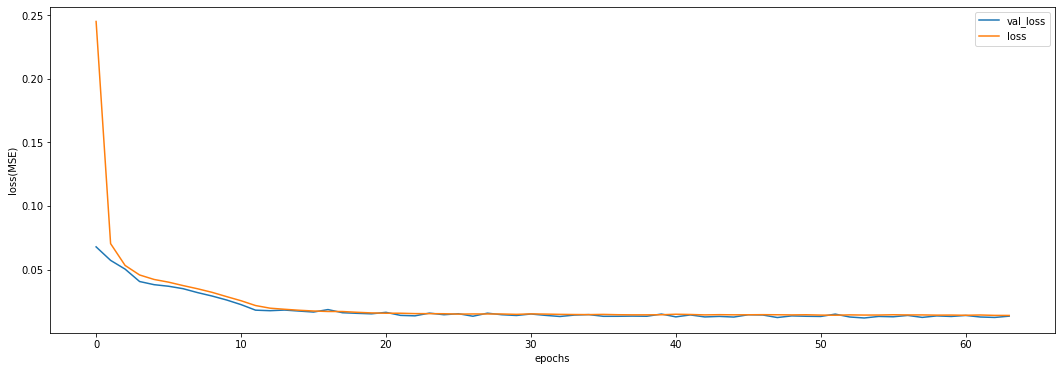

In [29]:
from numpy.random import seed



seed(1)
tf.random.set_seed(1)

# define model
model = Sequential()
model.add(Bidirectional(LSTM(100, activation='relu', input_shape=(n_steps_in, n_features))))
model.add(RepeatVector(n_steps_out))
model.add(Bidirectional(LSTM(100, activation='relu', return_sequences=True)))
model.add(TimeDistributed(Dense(n_features)))
model.compile(optimizer='adam', loss='mse')

# where to store the init model weights
file_loc = make_folder()
mc = ModelCheckpoint(file_loc, monitor='val_loss', mode='min', save_best_only=True)
es = EarlyStopping(monitor='val_loss', mode='min', patience=10)

t0= time.clock()
# fit model
history = model.fit(train_X, train_y, validation_data=(val_X, val_y), epochs=100, verbose=0, callbacks=[es,mc])
t1= time.clock() - t0
print('time taken:', t1)

saved_model = load_model(file_loc)
print('val loss:', saved_model.evaluate(val_X, val_y))
print('test loss:', saved_model.evaluate(test_X, test_y))



plot_history(history)

## steps = 12, steps out 12

In [30]:
n_steps_in, n_steps_out = 12, 12

train_X, train_y = split_sequences(train, n_steps_in, n_steps_out)
val_X, val_y = split_sequences(val, n_steps_in, n_steps_out)
test_X, test_y = split_sequences(test, n_steps_in, n_steps_out)

# print(test)

n_features = train_X.shape[2]
print(n_features)

8


time taken: 23.482034999999996
1/1 [==============================] - 0s 1ms/step - loss: 0.0140
val loss: 0.014021779410541058
2/2 [==============================] - 0s 4ms/step - loss: 0.0147
test loss: 0.014728553593158722


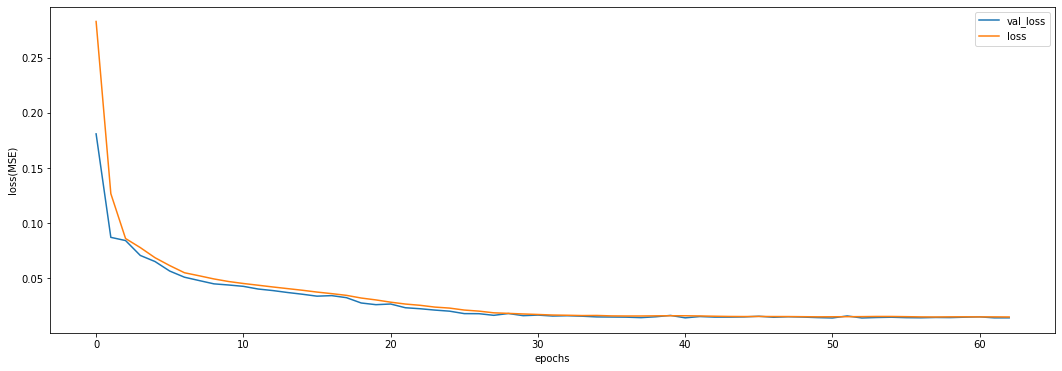

In [31]:
from numpy.random import seed



seed(1)
tf.random.set_seed(1)

# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_steps_in, n_features)))
model.add(RepeatVector(n_steps_out))
model.add(LSTM(100, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(n_features)))
model.compile(optimizer='adam', loss='mse')

# where to store the init model weights
file_loc = make_folder()
mc = ModelCheckpoint(file_loc, monitor='val_loss', mode='min', save_best_only=True)
es = EarlyStopping(monitor='val_loss', mode='min', patience=10)

t0= time.clock()
# fit model
history = model.fit(train_X, train_y, validation_data=(val_X, val_y), epochs=100, verbose=0, callbacks=[es,mc])
t1= time.clock() - t0
print('time taken:', t1)

saved_model = load_model(file_loc)
print('val loss:', saved_model.evaluate(val_X, val_y))
print('test loss:', saved_model.evaluate(test_X, test_y))



plot_history(history)

time taken: 60.93754299999995
1/1 [==============================] - 0s 1ms/step - loss: 0.0139
val loss: 0.013946712017059326
2/2 [==============================] - 0s 10ms/step - loss: 0.0145
test loss: 0.014486735686659813


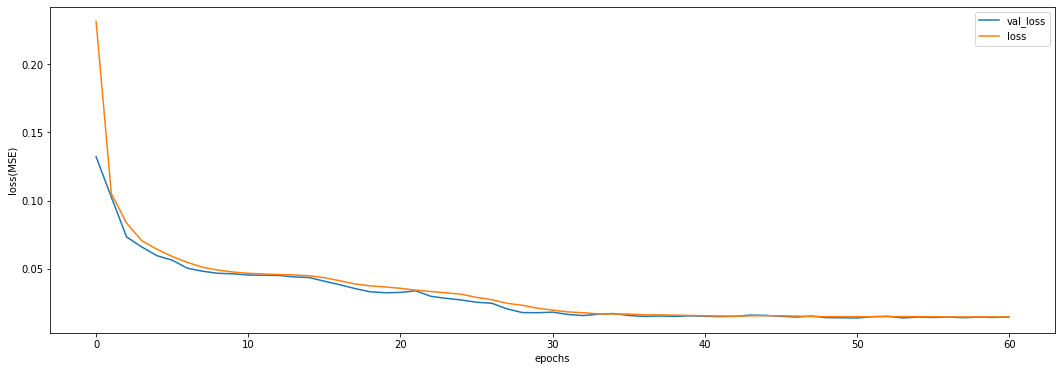

In [32]:
from numpy.random import seed



seed(1)
tf.random.set_seed(1)

# define model
model = Sequential()
model.add(LSTM(200, activation='relu', input_shape=(n_steps_in, n_features)))
model.add(RepeatVector(n_steps_out))
model.add(LSTM(200, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(n_features)))
model.compile(optimizer='adam', loss='mse')

# where to store the init model weights
file_loc = make_folder()
mc = ModelCheckpoint(file_loc, monitor='val_loss', mode='min', save_best_only=True)
es = EarlyStopping(monitor='val_loss', mode='min', patience=10)

t0= time.clock()
# fit model
history = model.fit(train_X, train_y, validation_data=(val_X, val_y), epochs=100, verbose=0, callbacks=[es,mc])
t1= time.clock() - t0
print('time taken:', t1)

saved_model = load_model(file_loc)
print('val loss:', saved_model.evaluate(val_X, val_y))
print('test loss:', saved_model.evaluate(test_X, test_y))



plot_history(history)


time taken: 52.15577000000002
1/1 [==============================] - 0s 1ms/step - loss: 0.0132
val loss: 0.0131920101121068
2/2 [==============================] - 0s 6ms/step - loss: 0.0142
test loss: 0.014215480536222458


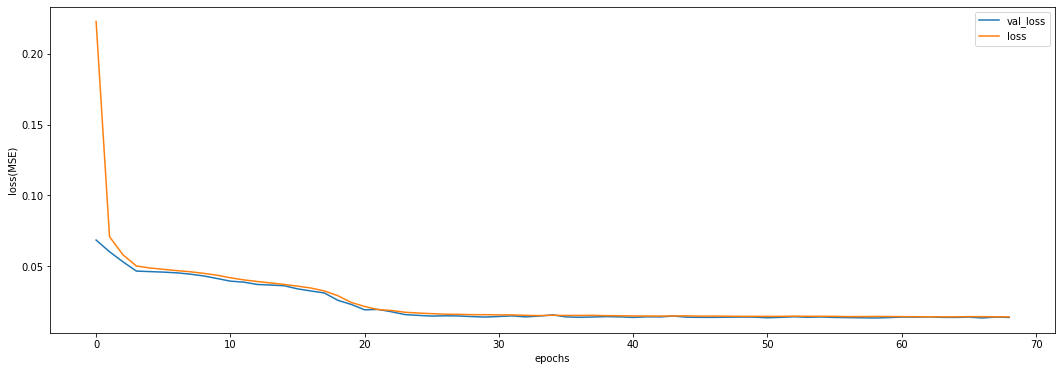

In [33]:
from numpy.random import seed



seed(1)
tf.random.set_seed(1)

# define model
model = Sequential()
model.add(Bidirectional(LSTM(100, activation='relu', input_shape=(n_steps_in, n_features))))
model.add(RepeatVector(n_steps_out))
model.add(Bidirectional(LSTM(100, activation='relu', return_sequences=True)))
model.add(TimeDistributed(Dense(n_features)))
model.compile(optimizer='adam', loss='mse')

# where to store the init model weights
file_loc = make_folder('best_LSTM.h5')
mc = ModelCheckpoint(file_loc, monitor='val_loss', mode='min', save_best_only=True)
es = EarlyStopping(monitor='val_loss', mode='min', patience=10)

t0= time.clock()
# fit model
history = model.fit(train_X, train_y, validation_data=(val_X, val_y), epochs=100, verbose=0, callbacks=[es,mc])
t1= time.clock() - t0
print('time taken:', t1)

saved_model = load_model(file_loc)
saved_model.save('best_LSTM.h5')
print('val loss:', saved_model.evaluate(val_X, val_y))
print('test loss:', saved_model.evaluate(test_X, test_y))



plot_history(history)

time taken: 94.355231
1/1 [==============================] - 0s 1ms/step - loss: 0.0139
val loss: 0.013948631472885609
2/2 [==============================] - 0s 17ms/step - loss: 0.0146
test loss: 0.014562198892235756


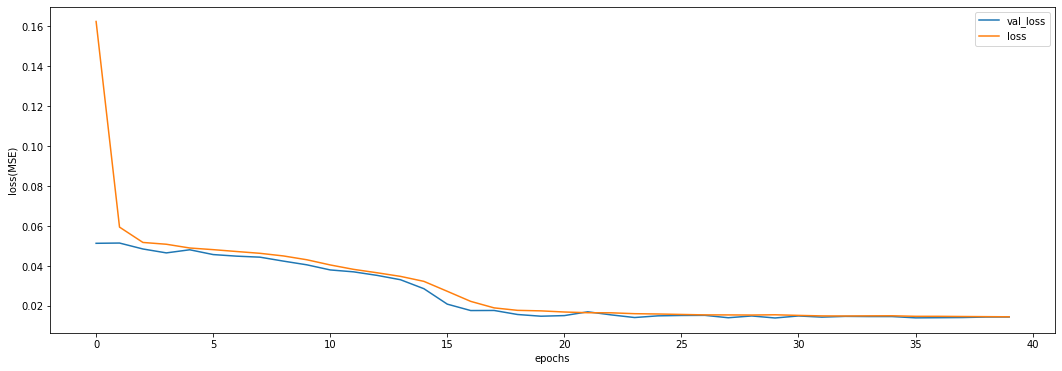

In [34]:
from numpy.random import seed



seed(1)
tf.random.set_seed(1)

# define model
model = Sequential()
model.add(Bidirectional(LSTM(200, activation='relu', input_shape=(n_steps_in, n_features))))
model.add(RepeatVector(n_steps_out))
model.add(Bidirectional(LSTM(200, activation='relu', return_sequences=True)))
model.add(TimeDistributed(Dense(n_features)))
model.compile(optimizer='adam', loss='mse')

# where to store the init model weights
file_loc = make_folder()
mc = ModelCheckpoint(file_loc, monitor='val_loss', mode='min', save_best_only=True)
es = EarlyStopping(monitor='val_loss', mode='min', patience=10)

t0= time.clock()
# fit model
history = model.fit(train_X, train_y, validation_data=(val_X, val_y), epochs=100, verbose=0, callbacks=[es,mc])
t1= time.clock() - t0
print('time taken:', t1)

saved_model = load_model(file_loc)
print('val loss:', saved_model.evaluate(val_X, val_y))
print('test loss:', saved_model.evaluate(test_X, test_y))



plot_history(history)

In [ ]:
saved_model = load_model(file_loc)

In [ ]:
saved_model.evaluate(val_X, val_y)

1/1 [==============================] - 0s 6ms/step - loss: 5.6837


5.683662414550781

In [ ]:
saved_model.evaluate(test_X, test_y)

2/2 [==============================] - 0s 14ms/step - loss: 7.0001


7.0000505447387695

In [ ]:
pred_input = test[-18:-6].reshape(1,12,6)

In [ ]:
prediction = model.predict(pred_input, verbose=1)

1/1 [==============================] - 0s 935us/step


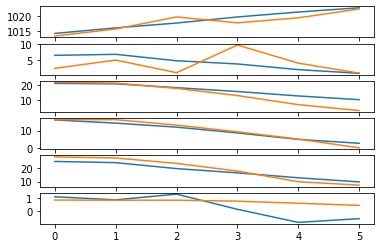

In [ ]:
fig, ax = plt.subplots(len(raw_data.columns),1)

for idx, col in enumerate(raw_data.columns):
  
  ax[idx].plot(prediction[0][:,idx])
  ax[idx].plot(test[-6:][:,idx])         


# use the saved weights as starting point

In [ ]:
high_corr_site_names = pd.read_csv('data_files/high_corr_site_names.csv', index_col=0)
high_corr_site_names.head()

,site_IDs
0,ELFI
1,VERMTL
2,TZEI
3,SWIT259
4,VERM11


## UK53

In [ ]:
file_loc = make_folder('best_LSTM.h5')
saved_model = load_model(file_loc)

In [ ]:
site =  'SWIT345'

def get_split_data(site):
  raw_data = get_all(site)
  dataset = norm_raw_data(raw_data)
  ttl_len = len(dataset)
  train = np.array(dataset.iloc[:int(ttl_len * 0.7)])
  val = np.array(dataset.iloc[int(ttl_len * 0.7):int(ttl_len * 0.8)])
  test = np.array(dataset.iloc[int(ttl_len * 0.8):])

  return (train, val, test)



train, val, test = get_split_data(site)

In [ ]:
n_steps_in, n_steps_out = 12, 12

train_X, train_y = split_sequences(train, n_steps_in, n_steps_out)
val_X, val_y = split_sequences(val, n_steps_in, n_steps_out)
test_X, test_y = split_sequences(test, n_steps_in, n_steps_out)

# print(test)

n_features = train_X.shape[2]

ELFI
time taken: 34.065702999999985
1/1 [==============================] - 0s 2ms/step - loss: 0.1550
val loss: 0.1549793928861618
2/2 [==============================] - 0s 7ms/step - loss: 0.1415
test loss: 0.14147202670574188
time taken: 10.6584170000001
1/1 [==============================] - 0s 2ms/step - loss: 0.1557
val loss: 0.15572941303253174
2/2 [==============================] - 0s 6ms/step - loss: 0.1407
test loss: 0.14066816866397858
VERMTL
time taken: 31.11948600000005
1/1 [==============================] - 0s 1ms/step - loss: 0.1095
val loss: 0.10945213586091995
2/2 [==============================] - 0s 7ms/step - loss: 0.1941
test loss: 0.1941073089838028
time taken: 11.5276080000001
1/1 [==============================] - 0s 1ms/step - loss: 0.1023
val loss: 0.10230199247598648
2/2 [==============================] - 0s 6ms/step - loss: 0.1963
test loss: 0.19632670283317566
TZEI
time taken: 29.36052399999994
1/1 [==============================] - 0s 2ms/step - loss: 0.155

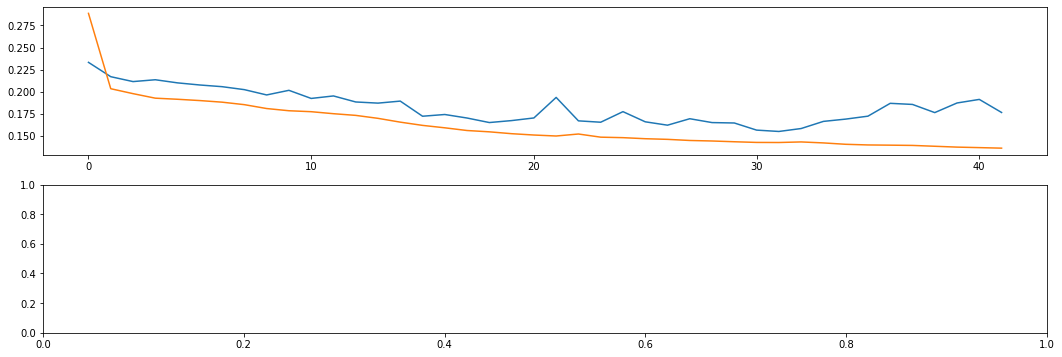

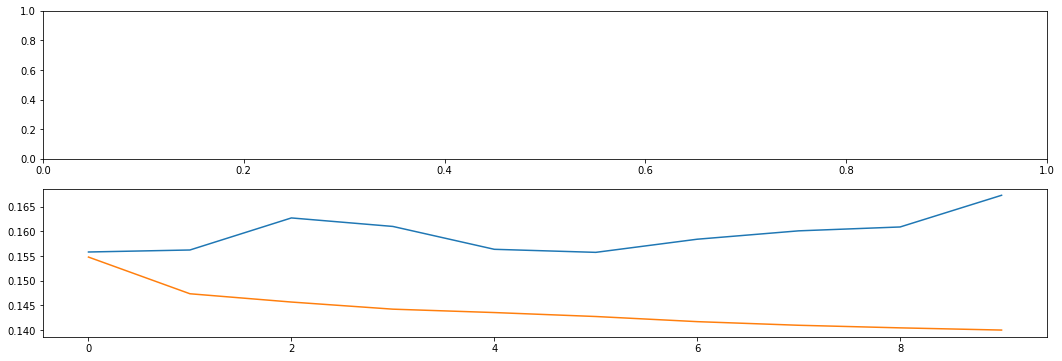

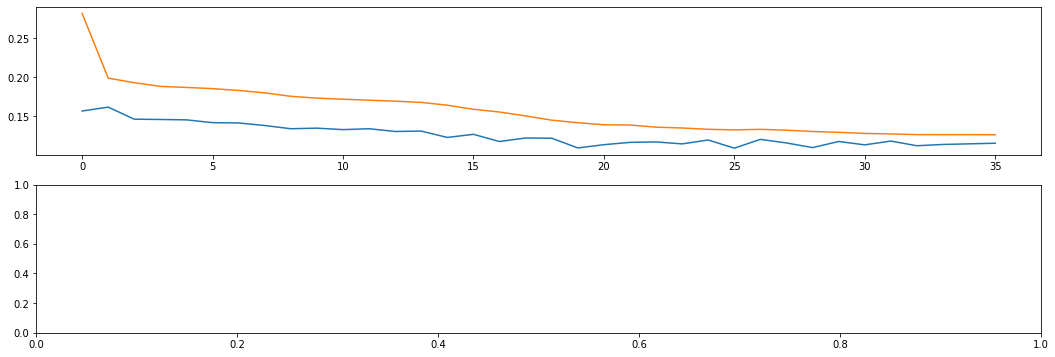

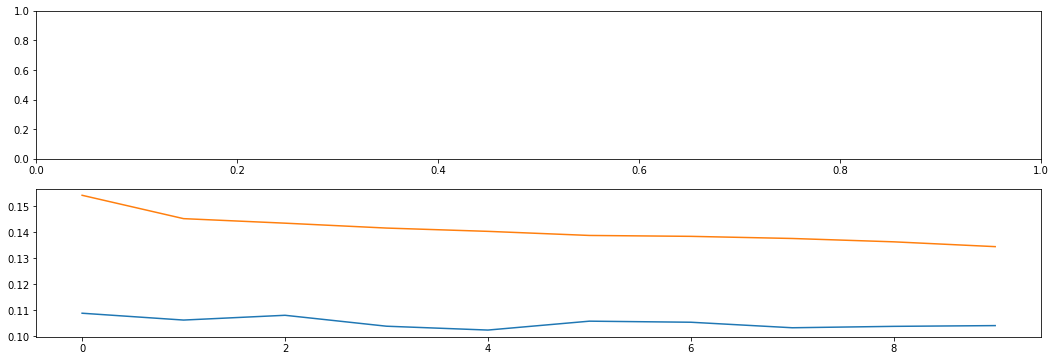

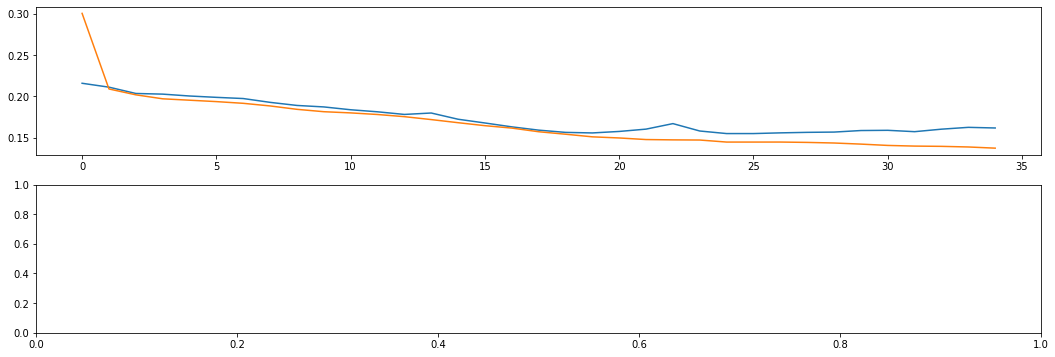

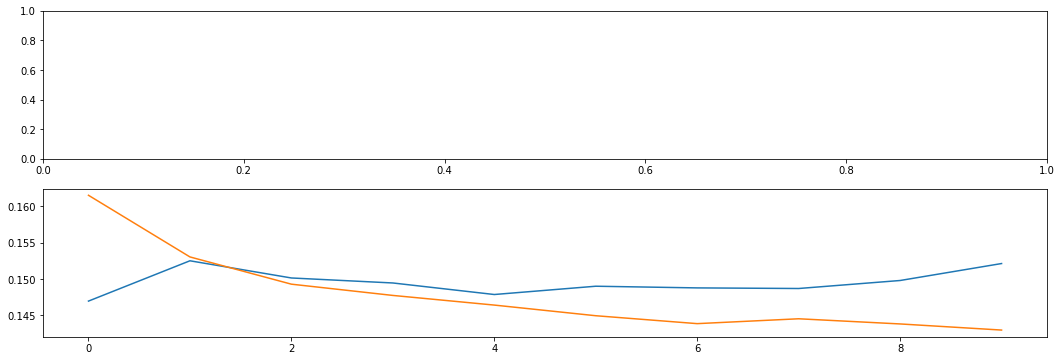

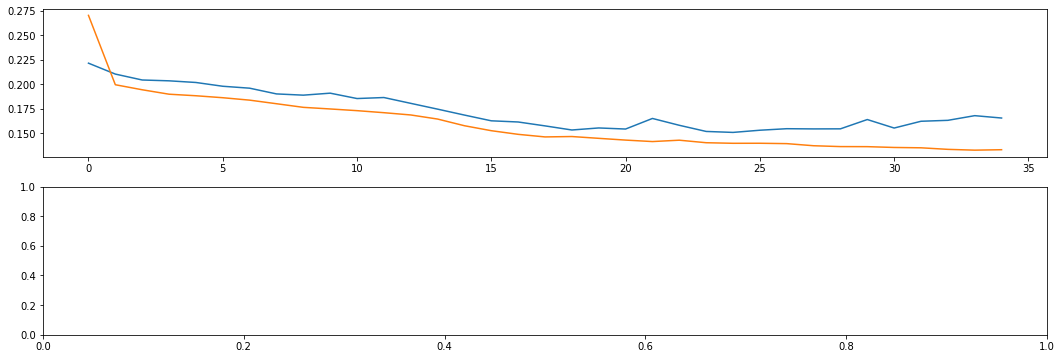

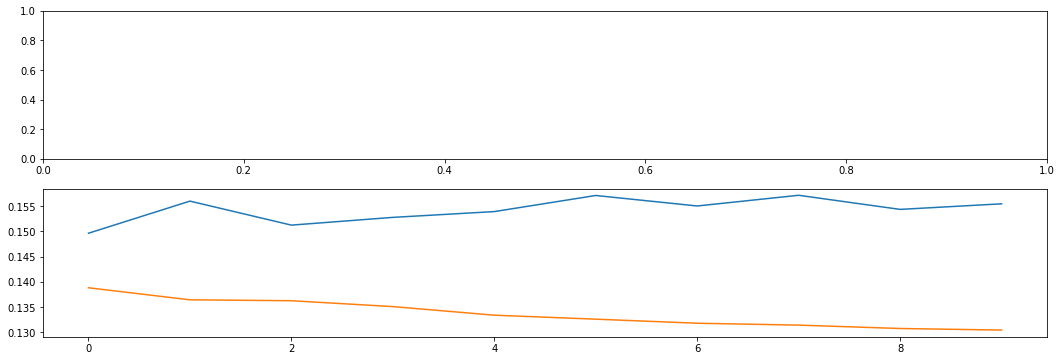

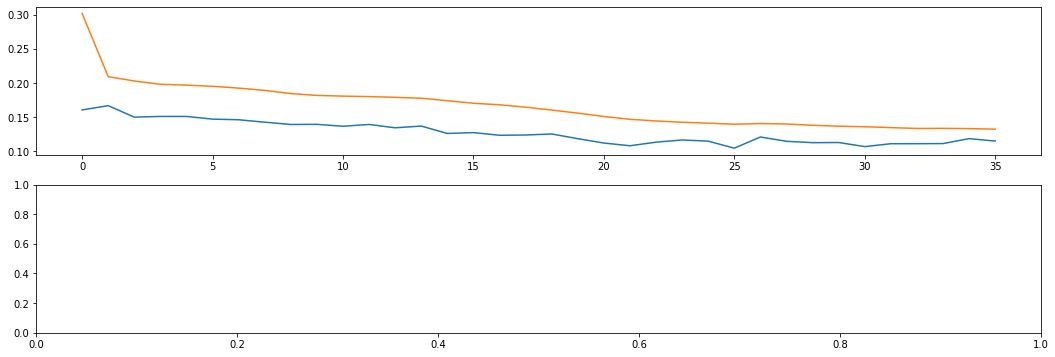

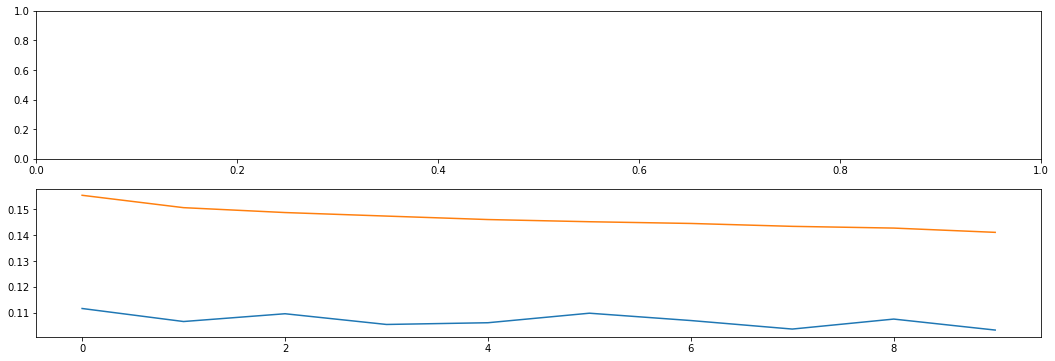

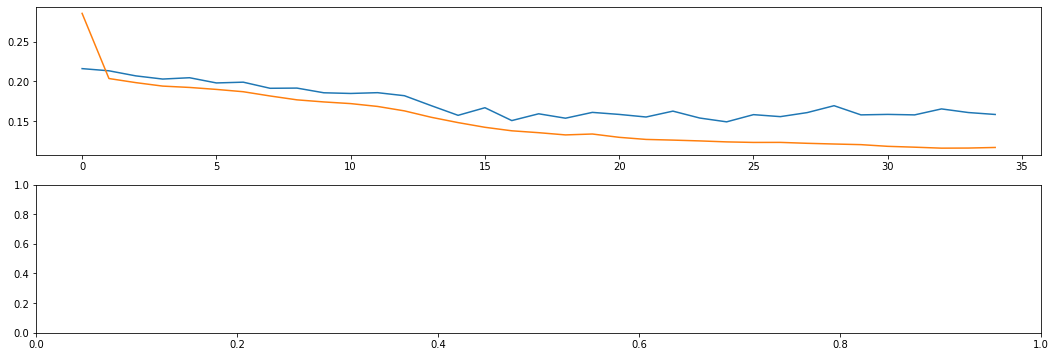

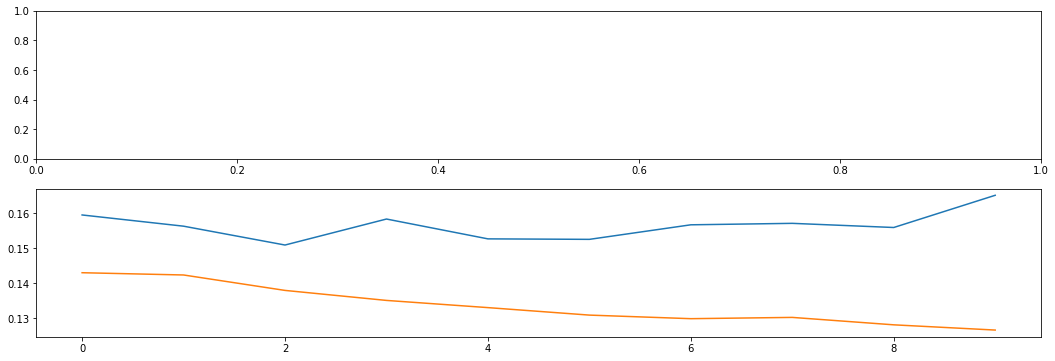

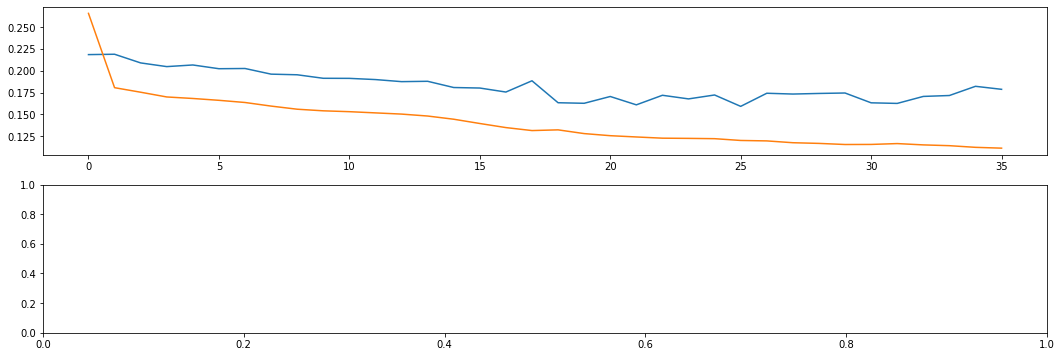

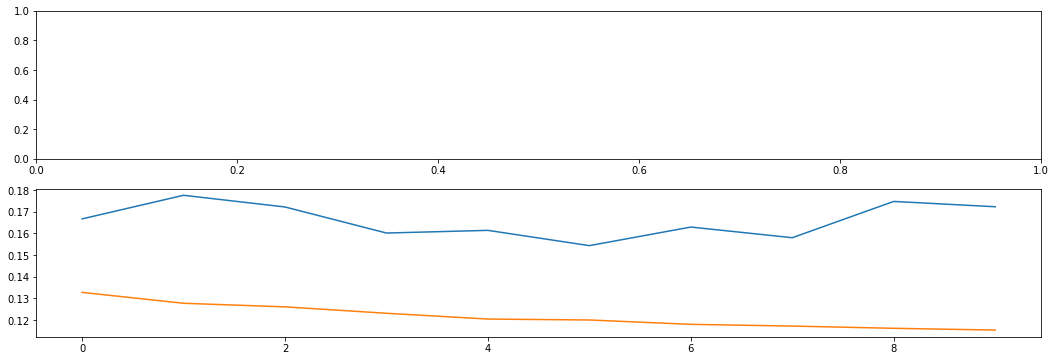

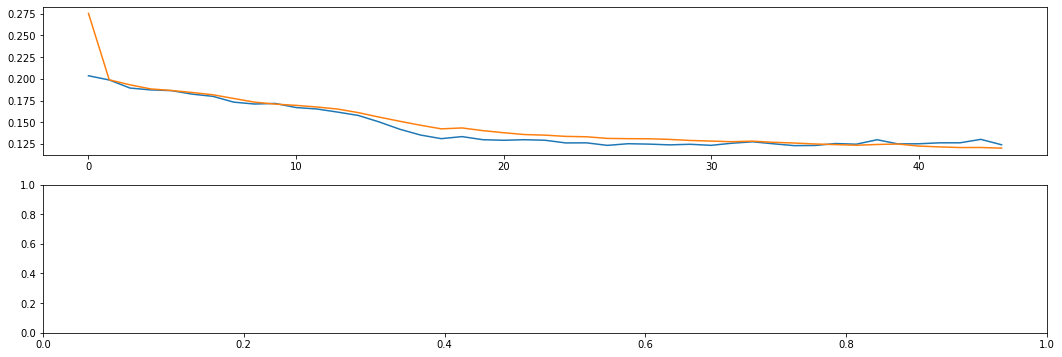

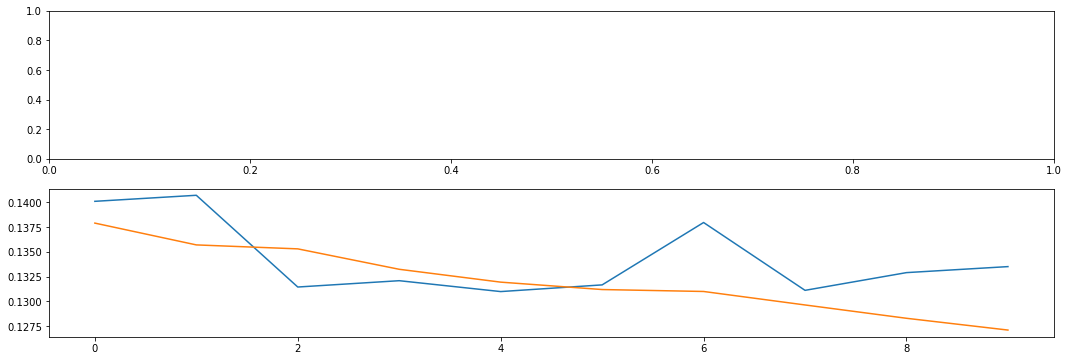

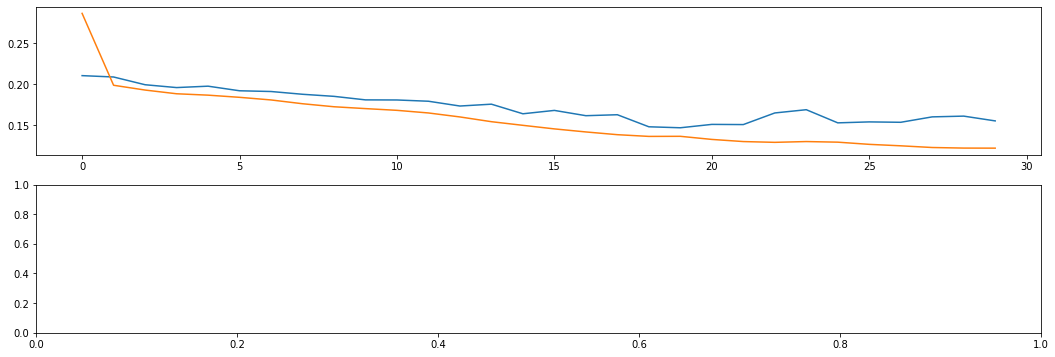

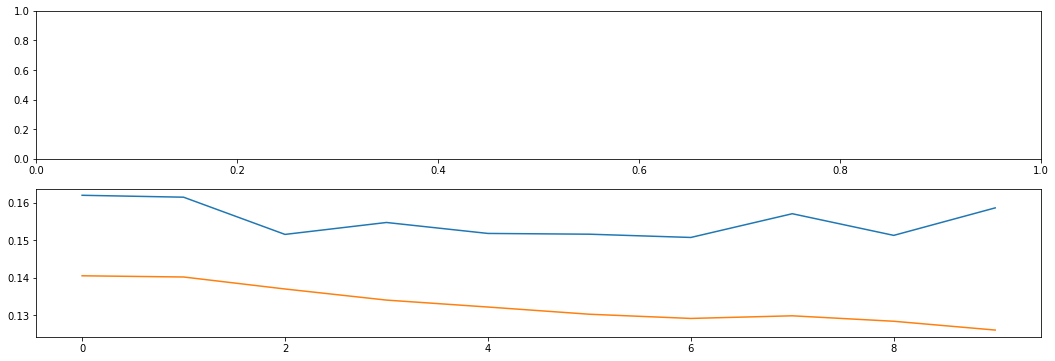

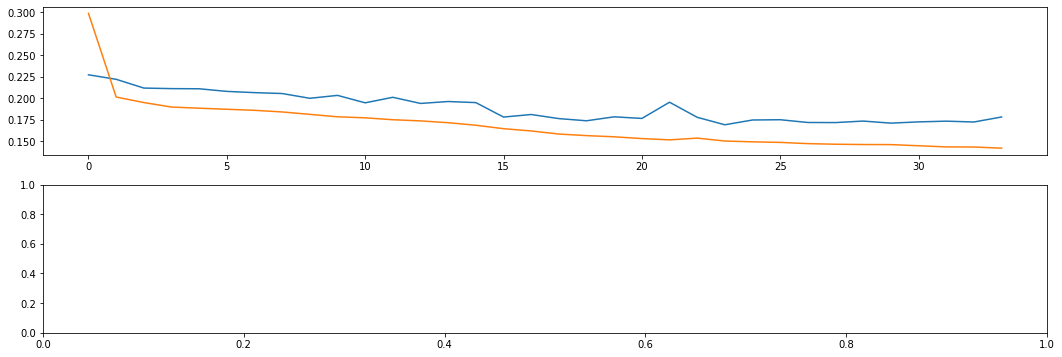

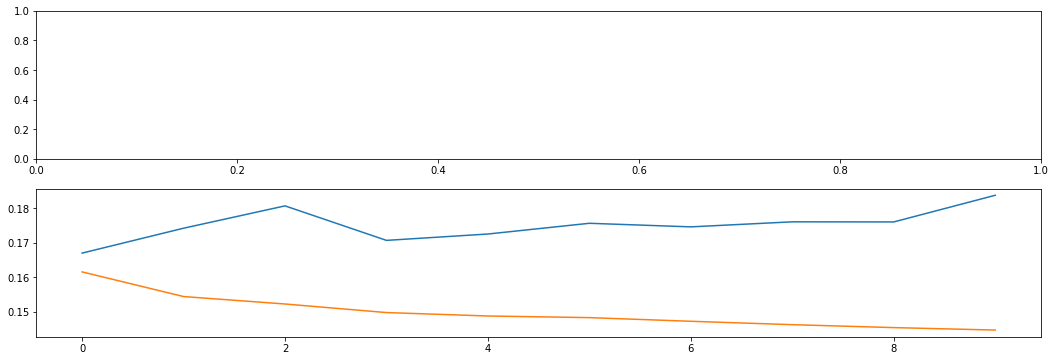

In [ ]:
import matplotlib.pyplot as plt

high_corr_site_names = pd.read_csv('data_files/high_corr_site_names.csv', index_col=0)


sites_of_interest = high_corr_site_names['site_IDs'][:10]
sites_of_interest

for site in sites_of_interest:
  train, val, test = get_split_data(site)

  n_steps_in, n_steps_out = 12, 12

  train_X, train_y = split_sequences(train, n_steps_in, n_steps_out)
  val_X, val_y = split_sequences(val, n_steps_in, n_steps_out)
  test_X, test_y = split_sequences(test, n_steps_in, n_steps_out)

  print(site)

  n_features = train_X.shape[2]

  for train_loop in range(2):
    from numpy.random import seed



    seed(1)
    tf.random.set_seed(1)

    if train_loop == 1:
      file_loc = make_folder('best_LSTM.h5')
      model = load_model(file_loc)
      epochs = 10
      
    
    else:
      # define model
      model = Sequential()
      model.add(Bidirectional(LSTM(100, activation='relu', input_shape=(n_steps_in, n_features))))
      model.add(RepeatVector(n_steps_out))
      model.add(Bidirectional(LSTM(100, activation='relu', return_sequences=True)))
      model.add(TimeDistributed(Dense(n_features)))
      model.compile(optimizer='adam', loss='mse')
      epochs = 100

    # where to store the init model weights
    file_loc = make_folder('temp.h5')
    mc = ModelCheckpoint(file_loc, monitor='val_loss', mode='min', save_best_only=True)
    es = EarlyStopping(monitor='val_loss', mode='min', patience=10)

    t0= time.clock()
    # fit model
    history = model.fit(train_X, train_y, validation_data=(val_X, val_y), epochs=epochs, verbose=0, callbacks=[es,mc])
    t1= time.clock() - t0
    print('time taken:', t1)

    saved_model = load_model(file_loc)
    print('val loss:', saved_model.evaluate(val_X, val_y))
    print('test loss:', saved_model.evaluate(test_X, test_y))



    fig, ax = plt.subplots(2,1)
    ax[train_loop].plot(history.history['val_loss'])
    ax[train_loop].plot(history.history['loss'])

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', patience=10)
history = saved_model.fit(train_X, train_y, validation_data=(val_X, val_y), epochs=100, verbose=0, callbacks=[es])

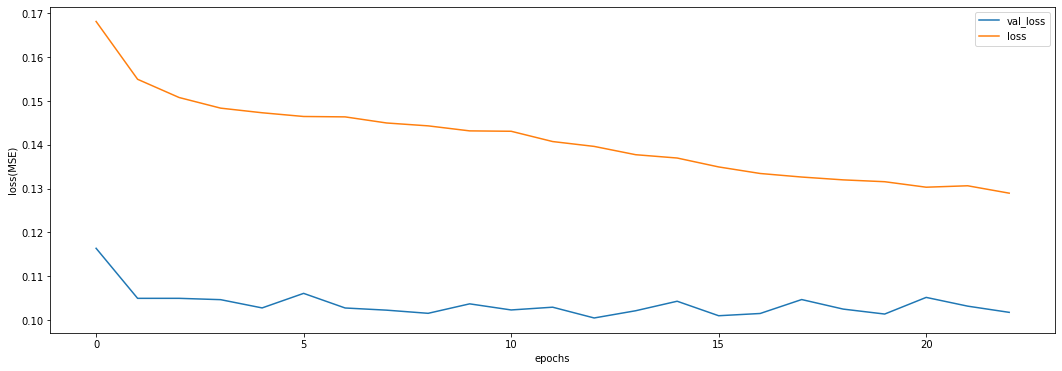

In [ ]:
plot_history(history)

In [ ]:
saved_model.evaluate(test_X, test_y)

2/2 [==============================] - 0s 7ms/step - loss: 0.2115


0.21153229475021362

## all interested sites

In [ ]:
file_loc = make_folder('best_LSTM.h5')
saved_model = load_model(file_loc)

In [ ]:
high_corr_site_names = pd.read_csv('data_files/high_corr_site_names.csv', index_col=0)


sites_of_interest = high_corr_site_names['site_IDs'][:10]
sites_of_interest

0       ELFI
1     VERMTL
2       TZEI
3    SWIT259
4     VERM11
5     Sinca3
6    CRO_CUD
7        MBA
8     Sinca6
9        E07
Name: site_IDs, dtype: object

In [ ]:
from numpy.random import seed

seed(2)
tf.random.set_seed(1)

test_score_list = []

for idx, site in enumerate(sites_of_interest):
  if idx > 0:
    #load the best weights from BiLSTM
    file_loc = make_folder('best_LSTM.h5')
    saved_model = load_model(file_loc)

    train, val, test = get_split_data(site)
    n_steps_in, n_steps_out = 12, 12

    train_X, train_y = split_sequences(train, n_steps_in, n_steps_out)
    val_X, val_y = split_sequences(val, n_steps_in, n_steps_out)
    test_X, test_y = split_sequences(test, n_steps_in, n_steps_out)

    # to save the tuned weights
    file_loc2 = make_folder('temp.h5')
    mc = ModelCheckpoint(file_loc2, monitor='val_loss', mode='min', save_best_only=True)
    t0= time.clock()
    history = saved_model.fit(train_X, train_y, validation_data=(val_X, val_y), epochs=10, verbose=0, callbacks=[mc])
    t1= time.clock() - t0
    print('time taken:', t1)

    saved_model = load_model(file_loc2)
    test_score_list.append(saved_model.evaluate(test_X, test_y))

print('mean testing loss:', np.mean(test_score_list))

time taken: 9.525561999999923
2/2 [==============================] - 0s 9ms/step - loss: 0.1963
time taken: 9.82065
2/2 [==============================] - 0s 7ms/step - loss: 0.1356
time taken: 9.142021999999997
2/2 [==============================] - 0s 7ms/step - loss: 0.1441
time taken: 9.143573999999944
2/2 [==============================] - 0s 8ms/step - loss: 0.2012
time taken: 8.99053600000002
2/2 [==============================] - 0s 8ms/step - loss: 0.1603
time taken: 9.19315000000006
2/2 [==============================] - 0s 8ms/step - loss: 0.1708
time taken: 9.196272000000022
2/2 [==============================] - 0s 10ms/step - loss: 0.1248
time taken: 9.22994600000004
2/2 [==============================] - 0s 7ms/step - loss: 0.1560
time taken: 9.11453599999993
2/2 [==============================] - 0s 8ms/step - loss: 0.1513
mean testing loss: 0.16006237102879417
